In [ ]:

import matplotlib.pyplot as plt
from textgrid import TextGrid
import numpy as np
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt_summary

# Load multilingual semantic model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

tg_ko_pwd = "./sound_sample/korean_yunjang/윤장목소리1.TextGrid"
tg_en_pwd = "./sound_sample/AI_eng_yunjang/mine_en.TextGrid"

# TextGrid load (you should change the path to your actual .TextGrid files)
tg_ko = TextGrid.fromFile(tg_ko_pwd)
tg_en = TextGrid.fromFile(tg_en_pwd)
tier_ko = tg_ko.getFirst("words")
tier_en = tg_en.getFirst("words")

# Meaning-based manual mapping
sentence_mapping = [
    (["안녕", "하", "세요"], ["hello"]),
    (["제", "이름", "은", "조윤장", "입니다"], ["my", "name", "is", "jo", "yoon", "jang"]),
    (["만나", "서", "반갑", "습니다"], ["nice", "to", "meet", "you"]),
    (["잘", "부탁", "드립니다"], ["please", "take", "care", "of", "me"])
]

def normalize(text):
    return text.replace(" ", "").replace(".", "").replace(",", "").lower()

def get_combined_text_and_time(tier, words):
    matched = []
    start, end = None, None
    for interval in tier:
        mark = normalize(interval.mark)
        if mark in [normalize(w) for w in words]:
            matched.append(interval.mark)
            if start is None:
                start = interval.minTime
            end = interval.maxTime
    return " ".join(matched), start, end

def estimate_tts_duration(text):
    words = text.strip().split()
    return len(words) * 0.3  # ~300ms per word

# Initialize values
dur_diffs = []
semantic_scores = []
pause_mismatches = []
relaxation_allowance = 0.3
speaking_rate_errors = []
visual_data = []

for i, (ko_words, en_words) in enumerate(sentence_mapping):
    ko_text, ko_start, ko_end = get_combined_text_and_time(tier_ko, ko_words)
    en_text, en_start, en_end = get_combined_text_and_time(tier_en, en_words)

    if not ko_text or not en_text:
        continue

    ko_dur = ko_end - ko_start
    en_dur = en_end - en_start
    dur_diff = abs(ko_dur - en_dur)
    dur_diffs.append(max(0, dur_diff - 0.3))

    emb_ko = model.encode(ko_text, convert_to_tensor=True)
    emb_en = model.encode(en_text, convert_to_tensor=True)
    sem_score = util.cos_sim(emb_ko, emb_en).item()
    semantic_scores.append(sem_score)

    ko_tts = estimate_tts_duration(ko_text)
    en_tts = estimate_tts_duration(en_text)
    rate_ko = ko_tts / ko_dur
    rate_en = en_tts / en_dur
    speaking_rate_errors.append(abs(rate_ko - rate_en))

    def count_pauses(tier, start, end):
        return sum(1 for i in tier if not normalize(i.mark) and i.minTime >= start and i.maxTime <= end)

    pause_ko = count_pauses(tier_ko, ko_start, ko_end)
    pause_en = count_pauses(tier_en, en_start, en_end)
    pause_mismatches.append(abs(pause_ko - pause_en))

    visual_data.append({
        "label": f"Sent {i+1}",
        "ko_start": ko_start,
        "ko_dur": ko_dur,
        "en_start": en_start,
        "en_dur": en_dur
    })

iso_score = 1 - (np.mean(dur_diffs) / max(tier_ko.maxTime, tier_en.maxTime))
sem_score = np.mean(semantic_scores)
rate_score = 1 - (np.mean(speaking_rate_errors) / max(rate_ko, rate_en))
pause_score = 1 - (np.mean(pause_mismatches) / max(len(sentence_mapping), 1))

print(f"Isochrony Score (with relaxation): {iso_score:.3f}")
print(f"Semantic Match Score: {sem_score:.3f}")
print(f"Speaking Rate Match Score: {rate_score:.3f}")
print(f"Pause Matching Score: {pause_score:.3f}")

# Timeline visualization
fig, ax = plt.subplots(figsize=(10, len(visual_data)))
for idx, entry in enumerate(visual_data):
    ax.broken_barh([(entry['ko_start'], entry['ko_dur'])], (idx*2 + 0.2, 0.6), facecolors='tab:blue', label='Korean' if idx == 0 else "")
    ax.broken_barh([(entry['en_start'], entry['en_dur'])], (idx*2 + 1.0, 0.6), facecolors='tab:orange', label='English' if idx == 0 else "")
    ax.text(0, idx*2 + 0.1, entry['label'], fontsize=9, verticalalignment='bottom')
ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.set_title("Prosodic Alignment Visualization")
ax.legend()
plt.tight_layout()
plt.savefig("alignment_timeline.png")

# Radar chart
df = pd.DataFrame([
    ["Isochrony", iso_score],
    ["Semantic", sem_score],
    ["Rate Match", rate_score],
    ["Pause Match", pause_score]
], columns=["Metric", "Score"])

categories = df["Metric"].values
values = df["Score"].values
values = np.concatenate((values, [values[0]]))

angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
angles += angles[:1]

fig_summary, ax2 = plt_summary.subplots(subplot_kw=dict(polar=True))
ax2.plot(angles, values, linewidth=2, linestyle='solid')
ax2.fill(angles, values, 'b', alpha=0.2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_title("Dubbing Prosody Quality Radar Chart", y=1.08)
ax2.set_yticklabels([])
plt_summary.tight_layout()
plt_summary.savefig("alignment_radar_chart.png")


FileNotFoundError: [Errno 2] No such file or directory: '윤장목소리1.TextGrid'

Isochrony Score (with relaxation): 0.949
Semantic Match Score: 0.657
Speaking Rate Match Score: 0.422
Pause Matching Score: 0.812


ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

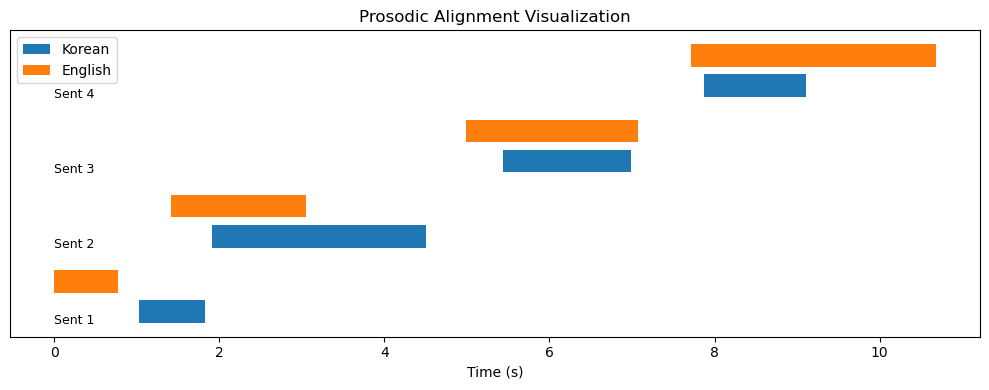

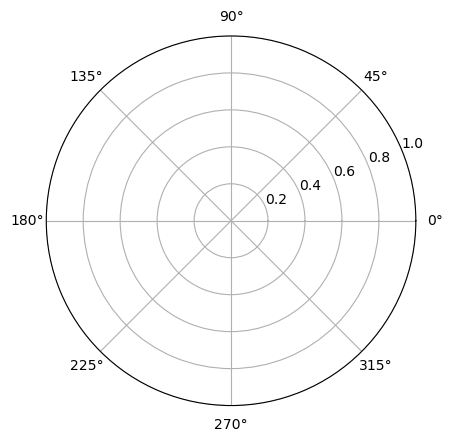

In [6]:

import matplotlib.pyplot as plt
from textgrid import TextGrid
import numpy as np
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt_summary

# Load multilingual semantic model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

tg_ko_pwd = "./sound_sample/korean_yunjang/윤장목소리1.TextGrid"
tg_en_pwd = "./sound_sample/AI_eng_yunjang/mine_en.TextGrid"

# TextGrid load (you should change the path to your actual .TextGrid files)
tg_ko = TextGrid.fromFile(tg_ko_pwd)
tg_en = TextGrid.fromFile(tg_en_pwd)
tier_ko = tg_ko.getFirst("words")
tier_en = tg_en.getFirst("words")

# Meaning-based manual mapping
sentence_mapping = [
    (["안녕", "하", "세요"], ["hello"]),
    (["제", "이름", "은", "조윤장", "입니다"], ["my", "name", "is", "jo", "yoon", "jang"]),
    (["만나", "서", "반갑", "습니다"], ["nice", "to", "meet", "you"]),
    (["잘", "부탁", "드립니다"], ["please", "take", "care", "of", "me"])
]

def normalize(text):
    return text.replace(" ", "").replace(".", "").replace(",", "").lower()

def get_combined_text_and_time(tier, words):
    matched = []
    start, end = None, None
    for interval in tier:
        mark = normalize(interval.mark)
        if mark in [normalize(w) for w in words]:
            matched.append(interval.mark)
            if start is None:
                start = interval.minTime
            end = interval.maxTime
    return " ".join(matched), start, end

def estimate_tts_duration(text):
    words = text.strip().split()
    return len(words) * 0.3  # ~300ms per word

# Initialize values
dur_diffs = []
semantic_scores = []
pause_mismatches = []
relaxation_allowance = 0.3
speaking_rate_errors = []
visual_data = []

for i, (ko_words, en_words) in enumerate(sentence_mapping):
    ko_text, ko_start, ko_end = get_combined_text_and_time(tier_ko, ko_words)
    en_text, en_start, en_end = get_combined_text_and_time(tier_en, en_words)

    if not ko_text or not en_text:
        continue

    ko_dur = ko_end - ko_start
    en_dur = en_end - en_start
    dur_diff = abs(ko_dur - en_dur)
    dur_diffs.append(max(0, dur_diff - 0.3))

    emb_ko = model.encode(ko_text, convert_to_tensor=True)
    emb_en = model.encode(en_text, convert_to_tensor=True)
    sem_score = util.cos_sim(emb_ko, emb_en).item()
    semantic_scores.append(sem_score)

    ko_tts = estimate_tts_duration(ko_text)
    en_tts = estimate_tts_duration(en_text)
    rate_ko = ko_tts / ko_dur
    rate_en = en_tts / en_dur
    speaking_rate_errors.append(abs(rate_ko - rate_en))

    def count_pauses(tier, start, end):
        return sum(1 for i in tier if not normalize(i.mark) and i.minTime >= start and i.maxTime <= end)

    pause_ko = count_pauses(tier_ko, ko_start, ko_end)
    pause_en = count_pauses(tier_en, en_start, en_end)
    pause_mismatches.append(abs(pause_ko - pause_en))

    visual_data.append({
        "label": f"Sent {i+1}",
        "ko_start": ko_start,
        "ko_dur": ko_dur,
        "en_start": en_start,
        "en_dur": en_dur
    })

iso_score = 1 - (np.mean(dur_diffs) / max(tier_ko.maxTime, tier_en.maxTime))
sem_score = np.mean(semantic_scores)
rate_score = 1 - (np.mean(speaking_rate_errors) / max(rate_ko, rate_en))
pause_score = 1 - (np.mean(pause_mismatches) / max(len(sentence_mapping), 1))

print(f"Isochrony Score (with relaxation): {iso_score:.3f}")
print(f"Semantic Match Score: {sem_score:.3f}")
print(f"Speaking Rate Match Score: {rate_score:.3f}")
print(f"Pause Matching Score: {pause_score:.3f}")

# Timeline visualization
fig, ax = plt.subplots(figsize=(10, len(visual_data)))
for idx, entry in enumerate(visual_data):
    ax.broken_barh([(entry['ko_start'], entry['ko_dur'])], (idx*2 + 0.2, 0.6), facecolors='tab:blue', label='Korean' if idx == 0 else "")
    ax.broken_barh([(entry['en_start'], entry['en_dur'])], (idx*2 + 1.0, 0.6), facecolors='tab:orange', label='English' if idx == 0 else "")
    ax.text(0, idx*2 + 0.1, entry['label'], fontsize=9, verticalalignment='bottom')
ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.set_title("Prosodic Alignment Visualization")
ax.legend()
plt.tight_layout()
plt.savefig("alignment_timeline.png")

# Radar chart
df = pd.DataFrame([
    ["Isochrony", iso_score],
    ["Semantic", sem_score],
    ["Rate Match", rate_score],
    ["Pause Match", pause_score]
], columns=["Metric", "Score"])

categories = df["Metric"].values
values = df["Score"].values
values = np.concatenate((values, [values[0]])) 

angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False) 
angles = np.concatenate((angles, [angles[0]]))

fig_summary, ax2 = plt_summary.subplots(subplot_kw=dict(polar=True))
ax2.plot(angles, values, linewidth=2, linestyle='solid')
ax2.fill(angles, values, 'b', alpha=0.2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_title("Dubbing Prosody Quality Radar Chart", y=1.08)
ax2.set_yticklabels([])
plt_summary.tight_layout()
plt_summary.savefig("alignment_radar_chart.png")
